# 03_Coverage

TODO: Bin evenly

Gini index: rank the bins by coverage (per cell)
Mean absolute deviation of coverage
insert size distribution per cell

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os
import tqdm
import pysam
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
results_dir = '/broad/thechenlab/ClaudiaC/droplet_DNA/sandbox/results/03'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

In [32]:
colon_dna_fn = '/broad/thechenlab/pipeline_slidetag/data/240609_SL-EXC_0308_A22KHFYLT3/count'
colon_rna_fn = '/broad/thechenlab/Benno/experiments/xBO153/cellranger'
colon_spatial_fn = '/broad/thechenlab/Andy/slide_tag_dna/colon_droplet/data/Mehdi_smaht_153_celltypes_locations.csv'
# bam_fn = '/broad/thechenlab/Benno/experiments/xBO153/cellranger/xBO153_GEX_240625/outs/possorted_genome_bam.bam' # RNA
bam_fn = '/broad/thechenlab/Benno/experiments/xBO153/bams/xBO153_G.markdup.bam' 
maf_fn = '/broad/thechenlab/ClaudiaC/droplet_DNA/data/xSDS_variants.txt'

# mapping barcodes
atac_bcs_fn = '/broad/thechenlab/Andy/software/cellranger-arc-2.0.2/lib/python/atac/barcodes/737K-arc-v1.txt.gz'
rna_bcs_fn = '/broad/thechenlab/Andy/software/cellranger-arc-2.0.2/lib/python/cellranger/barcodes/737K-arc-v1.txt.gz'

cytobands_fn = '/broad/thechenlab/ClaudiaC/droplet_DNA/refs/cytoBand.txt.gz'

In [6]:
with pysam.AlignmentFile(bam_fn, "rb") as bam:
    bam_header = bam.header.to_dict()

In [26]:
genome_bins_fn = f'{results_dir}/genome_bins.100k.bed'
genome_bins_fn

'/broad/thechenlab/ClaudiaC/droplet_DNA/sandbox/results/03/genome_bins.100k.bed'

In [38]:
bed_dfs = []
bin_size = 1_000_000 
for contig in bam_header['SQ']:
    contig_name = contig['SN']
    contig_len = contig['LN']
    
    bins = np.arange(0, contig_len + bin_size, bin_size)
    bed_df = pd.DataFrame({'chr': [contig_name] * (len(bins) - 1), 'start': bins[:-1], 'end': bins[1:]})
    bed_dfs.append(bed_df)
all_bed_dfs = pd.concat(bed_dfs)

In [39]:
all_bed_dfs.to_csv(genome_bins_fn, sep='\t', header=None, index=None)

In [40]:
binned_depth_fn = f'{results_dir}/binned_depth.1M.txt'
binned_depth_fn

'/broad/thechenlab/ClaudiaC/droplet_DNA/sandbox/results/03/binned_depth.1M.txt'

NOT separated by CB
```bash
use UGER
use Anaconda
use .samtools-1.9
samtools depth -a -b /broad/thechenlab/ClaudiaC/droplet_DNA/sandbox/results/03/genome_bins.100k.bed  /broad/thechenlab/Benno/experiments/xBO153/bams/xBO153_G.markdup.bam > /broad/thechenlab/ClaudiaC/droplet_DNA/sandbox/results/03/binned_depth.100k.txt
```

In [41]:
genome_bins_df = pd.read_csv(genome_bins_fn, sep='\t', header=None)
genome_bins_df.columns = ['chr', 'start', 'end']

In [42]:
genome_bins_df.shape

(3103, 3)

In [86]:
fn = '/broad/thechenlab/ClaudiaC/droplet_DNA/sandbox/results/03/binned_coverage.by_CB.txt'
bed_fn = '/broad/thechenlab/ClaudiaC/droplet_DNA/sandbox/results/03/binned_coverage.by_CB.all_beds.tsv'
df = pd.read_csv(fn, sep='\t', index_col=[0, 1])
bed_df = pd.read_csv(bed_fn, sep='\t', index_col=0)

In [87]:
reformat_df = df.sort_index().unstack()['0']

In [83]:
full_df = pd.concat([bed_df.iloc[:20], reformat_df], axis=1)

<Axes: >

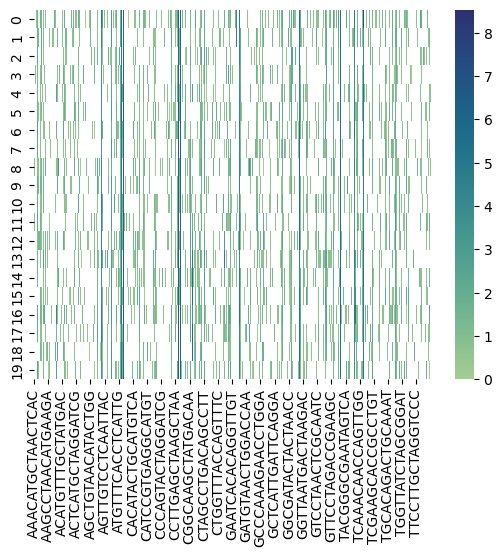

In [90]:
sns.heatmap(np.log(reformat_df), cmap='crest')

In [91]:
reformat_df.sum()

AAACATGCTAACTCAC     2.0
AAACATGCTAAGGATT     1.0
AAACATGCTACCTATG     2.0
AAACATGCTAGCCAGA     4.0
AAACATGCTAGCTAAA    19.0
                    ... 
TTTGTGTGATTACGTT     4.0
TTTGTGTGATTAGGTG    10.0
TTTGTGTGATTCCTGG     8.0
TTTGTGTGATTCCTTC    26.0
TTTGTGTGATTGCTAT     2.0
Length: 82205, dtype: float64